# Setup and Configuration

In [ ]:
"""
DenseNet-121 for NIH Chest X-ray Multi-label Classification
Google Colab Notebook - Complete Training Pipeline
"""

# ==================== SETUP & MOUNT DRIVE ====================
from google.colab import drive
drive.mount('/content/drive')

import os, sys, platform
print('='*70)
print('ENVIRONMENT INFO')
print('='*70)
print('Python:', sys.version)
print('Platform:', platform.platform())
print('Drive mounted. Proceeding...')

# ==================== INSTALL DEPENDENCIES ====================
print('\n📦 Installing dependencies...')
!pip install -q torchvision timm scikit-learn matplotlib seaborn Pillow tqdm

# ==================== IMPORTS ====================
import numpy as np
import pandas as pd
import os, time, json
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print('✅ Imports complete')

# ==================== CONFIGURATION ====================
class Config:
    # Paths - MODIFY THESE TO MATCH YOUR STRUCTURE
    DATASET_PATH = '/content/drive/MyDrive/ML-Project/sample'
    IMAGES_PATH = os.path.join(DATASET_PATH, 'images')
    LABELS_CSV = os.path.join(DATASET_PATH, 'sample_labels.csv')
    MODEL_DIR = '/content/drive/MyDrive/ML-Project/models_densenet'

    # Diseases
    DISEASES = ['Cardiomegaly','Edema','Emphysema','Hernia','Pneumonia','Fibrosis','Pneumothorax']

    # Model
    MODEL_NAME = 'densenet121'  # Options: densenet121, densenet169, densenet201
    PRETRAINED = True

    # Training
    IMAGE_SIZE = 224
    BATCH_SIZE = 32  # Increase if you have enough GPU memory
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_WORKERS = 2  # Colab works well with 2

    # Hardware
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Training settings
    EARLY_STOPPING_PATIENCE = 5
    REDUCE_LR_PATIENCE = 3

    # Data split
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

config = Config()

# Create model directory
os.makedirs(config.MODEL_DIR, exist_ok=True)

print('\n' + '='*70)
print('CONFIGURATION')
print('='*70)
print(f'Device: {config.DEVICE}')
print(f'Model: {config.MODEL_NAME}')
print(f'Image size: {config.IMAGE_SIZE}')
print(f'Batch size: {config.BATCH_SIZE}')
print(f'Learning rate: {config.LEARNING_RATE}')
print(f'Epochs: {config.NUM_EPOCHS}')
print(f'Diseases: {len(config.DISEASES)}')
print('='*70)

# Check GPU
if torch.cuda.is_available():
    print(f'✅ GPU Available: {torch.cuda.get_device_name(0)}')
    print(f'   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
else:
    print('⚠️  No GPU detected. Training will be slow!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ENVIRONMENT INFO
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Drive mounted. Proceeding...

📦 Installing dependencies...
✅ Imports complete

CONFIGURATION
Device: cuda
Model: densenet121
Image size: 224
Batch size: 32
Learning rate: 0.0001
Epochs: 25
Diseases: 7
✅ GPU Available: Tesla T4
   GPU Memory: 15.83 GB


# Data Loading and Preprocessing

In [ ]:
# ==================== DATA LOADING ====================
print('\n📂 Loading dataset...')

assert os.path.exists(config.LABELS_CSV), f'❌ Labels CSV not found at {config.LABELS_CSV}'
assert os.path.exists(config.IMAGES_PATH), f'❌ Images path not found at {config.IMAGES_PATH}'

df = pd.read_csv(config.LABELS_CSV)
print(f'Loaded {len(df):,} rows from CSV')

# Build binary targets for each disease
for disease in config.DISEASES:
    df[disease] = df['Finding Labels'].astype(str).apply(lambda s: 1 if disease in s else 0)

# Add full image path
df['Image_Path'] = df['Image Index'].apply(lambda x: os.path.join(config.IMAGES_PATH, x))

# Verify images exist
print('Checking image paths...')
df = df[df['Image_Path'].apply(os.path.exists)].reset_index(drop=True)
print(f'✅ Valid images: {len(df):,}')

# Print disease distribution
print('\n📊 Disease Distribution:')
for disease in config.DISEASES:
    count = df[disease].sum()
    percentage = (count / len(df)) * 100
    print(f'  {disease:15s}: {count:5d} ({percentage:5.2f}%)')

# ==================== TRAIN/VAL/TEST SPLIT ====================
print('\n✂️  Splitting dataset...')

# Use stratification on most common disease for better split
stratify_col = config.DISEASES[0] if df[config.DISEASES[0]].sum() > 0 else None

train_df, temp_df = train_test_split(
    df,
    test_size=(config.VAL_RATIO + config.TEST_RATIO),
    random_state=42,
    stratify=df[stratify_col] if stratify_col else None
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=config.TEST_RATIO/(config.VAL_RATIO + config.TEST_RATIO),
    random_state=42,
    stratify=temp_df[stratify_col] if stratify_col else None
)

print(f'Train: {len(train_df):,} images')
print(f'Val:   {len(val_df):,} images')
print(f'Test:  {len(test_df):,} images')

# ==================== DATASET CLASS ====================
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.diseases = config.DISEASES

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        img_path = self.df.iloc[idx]['Image_Path']

        try:
            # Load as RGB
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f'Error loading {img_path}: {e}')
            # Return black image if error
            image = Image.new('RGB', (config.IMAGE_SIZE, config.IMAGE_SIZE), (0, 0, 0))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get multi-label targets and convert to float
        labels = torch.FloatTensor(self.df.iloc[idx][self.diseases].values.astype(float))

        return image, labels

# ==================== DATA AUGMENTATION ====================
print('\n🎨 Setting up data augmentation...')

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ChestXrayDataset(train_df, transform=train_transform)
val_dataset = ChestXrayDataset(val_df, transform=val_transform)
test_dataset = ChestXrayDataset(test_df, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f'✅ DataLoaders created')
print(f'   Train batches: {len(train_loader)}')
print(f'   Val batches:   {len(val_loader)}')
print(f'   Test batches:  {len(test_loader)}')


📂 Loading dataset...
Loaded 5,606 rows from CSV
Checking image paths...
✅ Valid images: 5,606

📊 Disease Distribution:
  Cardiomegaly   :   141 ( 2.52%)
  Edema          :   118 ( 2.10%)
  Emphysema      :   127 ( 2.27%)
  Hernia         :    13 ( 0.23%)
  Pneumonia      :    62 ( 1.11%)
  Fibrosis       :    84 ( 1.50%)
  Pneumothorax   :   271 ( 4.83%)

✂️  Splitting dataset...
Train: 3,924 images
Val:   841 images
Test:  841 images

🎨 Setting up data augmentation...
✅ DataLoaders created
   Train batches: 123
   Val batches:   27
   Test batches:  27


# Model Definition and Setup

In [ ]:
# ==================== MODEL ====================
print('\n🏗️  Building DenseNet-121 model...')

class DenseNetClassifier(nn.Module):
    def __init__(self, model_name='densenet121', num_classes=7, pretrained=True):
        super(DenseNetClassifier, self).__init__()

        if model_name == 'densenet121':
            self.model = models.densenet121(pretrained=pretrained)
            num_ftrs = self.model.classifier.in_features
        elif model_name == 'densenet169':
            self.model = models.densenet169(pretrained=pretrained)
            num_ftrs = self.model.classifier.in_features
        elif model_name == 'densenet201':
            self.model = models.densenet201(pretrained=pretrained)
            num_ftrs = self.model.classifier.in_features
        else:
            raise ValueError(f'Unknown model: {model_name}')

        # Replace classifier
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model
model = DenseNetClassifier(
    model_name=config.MODEL_NAME,
    num_classes=len(config.DISEASES),
    pretrained=config.PRETRAINED
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'✅ Model: {config.MODEL_NAME}')
print(f'   Total parameters: {total_params:,}')
print(f'   Trainable parameters: {trainable_params:,}')

# ==================== LOSS & OPTIMIZER ====================
print('\n⚙️  Setting up loss and optimizer...')

# Calculate positive class weights for imbalanced data
pos_counts = train_df[config.DISEASES].sum().values
neg_counts = len(train_df) - pos_counts
pos_weights = torch.FloatTensor(neg_counts / (pos_counts + 1e-5)).to(config.DEVICE)

print('Positive class weights:')
for disease, weight in zip(config.DISEASES, pos_weights):
    print(f'  {disease:15s}: {weight:.3f}')

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=config.REDUCE_LR_PATIENCE
)


🏗️  Building DenseNet-121 model...
✅ Model: densenet121
   Total parameters: 6,961,031
   Trainable parameters: 6,961,031

⚙️  Setting up loss and optimizer...
Positive class weights:
  Cardiomegaly   : 38.636
  Edema          : 52.753
  Emphysema      : 43.591
  Hernia         : 435.000
  Pneumonia      : 86.200
  Fibrosis       : 66.655
  Pneumothorax   : 19.653


# Training and Validation Functions

In [ ]:
# ==================== TRAINING FUNCTIONS ====================
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store predictions
        all_labels.append(labels.cpu().detach())
        all_preds.append(torch.sigmoid(outputs).cpu().detach())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate metrics
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    avg_loss = running_loss / len(dataloader)

    # Calculate AUC per disease
    auc_scores = []
    for i in range(len(config.DISEASES)):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        except:
            auc_scores.append(0.0)

    avg_auc = np.mean(auc_scores)

    return avg_loss, avg_auc, auc_scores

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            all_labels.append(labels.cpu())
            all_preds.append(torch.sigmoid(outputs).cpu())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate metrics
    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()

    avg_loss = running_loss / len(dataloader)

    # Calculate AUC per disease
    auc_scores = []
    for i in range(len(config.DISEASES)):
        try:
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        except:
            auc_scores.append(0.0)

    avg_auc = np.mean(auc_scores)

    return avg_loss, avg_auc, auc_scores, all_labels, all_preds

# Main Training Loop


STARTING TRAINING

📅 Epoch 1/25
----------------------------------------------------------------------



⏱️  Time: 1024.8s | LR: 0.000100
📉 Train Loss: 1.3180 | Train AUC: 0.6074
📊 Val Loss:   1.2489 | Val AUC:   0.7040

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.4571
  ✅ Edema          : 0.8471
  ⚠️ Emphysema      : 0.7704
  ✅ Hernia         : 0.9750
  ⚠️ Pneumonia      : 0.6672
  ⚠️ Fibrosis       : 0.4725
  ⚠️ Pneumothorax   : 0.7386

💾 Best model saved! (AUC: 0.7040)

📅 Epoch 2/25
----------------------------------------------------------------------



⏱️  Time: 121.4s | LR: 0.000100
📉 Train Loss: 1.1444 | Train AUC: 0.7654
📊 Val Loss:   1.1539 | Val AUC:   0.7796

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.5295
  ✅ Edema          : 0.8683
  ✅ Emphysema      : 0.8160
  ✅ Hernia         : 0.9482
  ⚠️ Pneumonia      : 0.7233
  ⚠️ Fibrosis       : 0.7868
  ⚠️ Pneumothorax   : 0.7852

💾 Best model saved! (AUC: 0.7796)

📅 Epoch 3/25
----------------------------------------------------------------------



⏱️  Time: 119.7s | LR: 0.000100
📉 Train Loss: 1.0354 | Train AUC: 0.8124
📊 Val Loss:   1.0943 | Val AUC:   0.7912

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.5767
  ✅ Edema          : 0.8593
  ✅ Emphysema      : 0.8371
  ✅ Hernia         : 0.9607
  ⚠️ Pneumonia      : 0.7240
  ✅ Fibrosis       : 0.8035
  ⚠️ Pneumothorax   : 0.7773

💾 Best model saved! (AUC: 0.7912)

📅 Epoch 4/25
----------------------------------------------------------------------



⏱️  Time: 121.4s | LR: 0.000100
📉 Train Loss: 0.9365 | Train AUC: 0.8502
📊 Val Loss:   1.1532 | Val AUC:   0.7787

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6250
  ✅ Edema          : 0.8659
  ✅ Emphysema      : 0.8655
  ⚠️ Hernia         : 0.7485
  ⚠️ Pneumonia      : 0.7334
  ✅ Fibrosis       : 0.8155
  ⚠️ Pneumothorax   : 0.7974

⏳ Patience: 1/5

📅 Epoch 5/25
----------------------------------------------------------------------



⏱️  Time: 119.0s | LR: 0.000100
📉 Train Loss: 0.8450 | Train AUC: 0.8812
📊 Val Loss:   1.1544 | Val AUC:   0.8049

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6505
  ✅ Edema          : 0.8405
  ✅ Emphysema      : 0.8584
  ✅ Hernia         : 0.8659
  ⚠️ Pneumonia      : 0.7634
  ✅ Fibrosis       : 0.8502
  ✅ Pneumothorax   : 0.8054

💾 Best model saved! (AUC: 0.8049)

📅 Epoch 6/25
----------------------------------------------------------------------



⏱️  Time: 123.3s | LR: 0.000100
📉 Train Loss: 0.7858 | Train AUC: 0.8997
📊 Val Loss:   1.1456 | Val AUC:   0.7878

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6412
  ✅ Edema          : 0.8646
  ✅ Emphysema      : 0.8517
  ✅ Hernia         : 0.8611
  ⚠️ Pneumonia      : 0.7734
  ⚠️ Fibrosis       : 0.7223
  ✅ Pneumothorax   : 0.8001

⏳ Patience: 1/5

📅 Epoch 7/25
----------------------------------------------------------------------



⏱️  Time: 136.3s | LR: 0.000100
📉 Train Loss: 0.8104 | Train AUC: 0.8919
📊 Val Loss:   1.1725 | Val AUC:   0.7804

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.5333
  ✅ Edema          : 0.8645
  ✅ Emphysema      : 0.8877
  ✅ Hernia         : 0.8933
  ⚠️ Pneumonia      : 0.6828
  ⚠️ Fibrosis       : 0.7761
  ✅ Pneumothorax   : 0.8251

⏳ Patience: 2/5

📅 Epoch 8/25
----------------------------------------------------------------------



⏱️  Time: 118.4s | LR: 0.000100
📉 Train Loss: 0.6857 | Train AUC: 0.9265
📊 Val Loss:   1.2534 | Val AUC:   0.8140

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6977
  ✅ Edema          : 0.8557
  ✅ Emphysema      : 0.9002
  ✅ Hernia         : 0.8951
  ✅ Pneumonia      : 0.8281
  ⚠️ Fibrosis       : 0.7043
  ✅ Pneumothorax   : 0.8172

💾 Best model saved! (AUC: 0.8140)

📅 Epoch 9/25
----------------------------------------------------------------------



⏱️  Time: 123.0s | LR: 0.000100
📉 Train Loss: 0.5679 | Train AUC: 0.9491
📊 Val Loss:   1.1714 | Val AUC:   0.8444

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.7290
  ✅ Edema          : 0.8668
  ✅ Emphysema      : 0.9193
  ✅ Hernia         : 0.9350
  ⚠️ Pneumonia      : 0.7938
  ✅ Fibrosis       : 0.8325
  ✅ Pneumothorax   : 0.8344

💾 Best model saved! (AUC: 0.8444)

📅 Epoch 10/25
----------------------------------------------------------------------



⏱️  Time: 121.8s | LR: 0.000100
📉 Train Loss: 0.4628 | Train AUC: 0.9665
📊 Val Loss:   1.1526 | Val AUC:   0.8423

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.7373
  ✅ Edema          : 0.8459
  ✅ Emphysema      : 0.8998
  ✅ Hernia         : 0.9851
  ⚠️ Pneumonia      : 0.7914
  ⚠️ Fibrosis       : 0.7914
  ✅ Pneumothorax   : 0.8452

⏳ Patience: 1/5

📅 Epoch 11/25
----------------------------------------------------------------------



⏱️  Time: 120.2s | LR: 0.000100
📉 Train Loss: 0.4517 | Train AUC: 0.9672
📊 Val Loss:   1.6342 | Val AUC:   0.8150

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.7244
  ✅ Edema          : 0.8286
  ✅ Emphysema      : 0.8602
  ✅ Hernia         : 0.9648
  ⚠️ Pneumonia      : 0.7165
  ⚠️ Fibrosis       : 0.7745
  ✅ Pneumothorax   : 0.8362

⏳ Patience: 2/5

📅 Epoch 12/25
----------------------------------------------------------------------



⏱️  Time: 120.5s | LR: 0.000100
📉 Train Loss: 0.3909 | Train AUC: 0.9755
📊 Val Loss:   1.4476 | Val AUC:   0.8257

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.7066
  ✅ Edema          : 0.8162
  ✅ Emphysema      : 0.8680
  ✅ Hernia         : 0.9696
  ⚠️ Pneumonia      : 0.7390
  ✅ Fibrosis       : 0.8397
  ✅ Pneumothorax   : 0.8408

⏳ Patience: 3/5

📅 Epoch 13/25
----------------------------------------------------------------------



⏱️  Time: 120.5s | LR: 0.000050
📉 Train Loss: 0.3219 | Train AUC: 0.9835
📊 Val Loss:   1.9423 | Val AUC:   0.8129

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6859
  ⚠️ Edema          : 0.7588
  ✅ Emphysema      : 0.9298
  ✅ Hernia         : 0.9577
  ⚠️ Pneumonia      : 0.6803
  ✅ Fibrosis       : 0.8415
  ✅ Pneumothorax   : 0.8365

⏳ Patience: 4/5

📅 Epoch 14/25
----------------------------------------------------------------------



⏱️  Time: 118.9s | LR: 0.000050
📉 Train Loss: 0.2442 | Train AUC: 0.9910
📊 Val Loss:   1.9918 | Val AUC:   0.8035

🏥 Per-disease AUC (Validation):
  ⚠️ Cardiomegaly   : 0.6739
  ⚠️ Edema          : 0.7938
  ✅ Emphysema      : 0.8951
  ✅ Hernia         : 0.9696
  ⚠️ Pneumonia      : 0.6799
  ⚠️ Fibrosis       : 0.7539
  ✅ Pneumothorax   : 0.8584

⏳ Patience: 5/5

🛑 Early stopping triggered after 14 epochs

✅ TRAINING COMPLETE!
Best validation AUC: 0.8444

📊 Plotting training history...


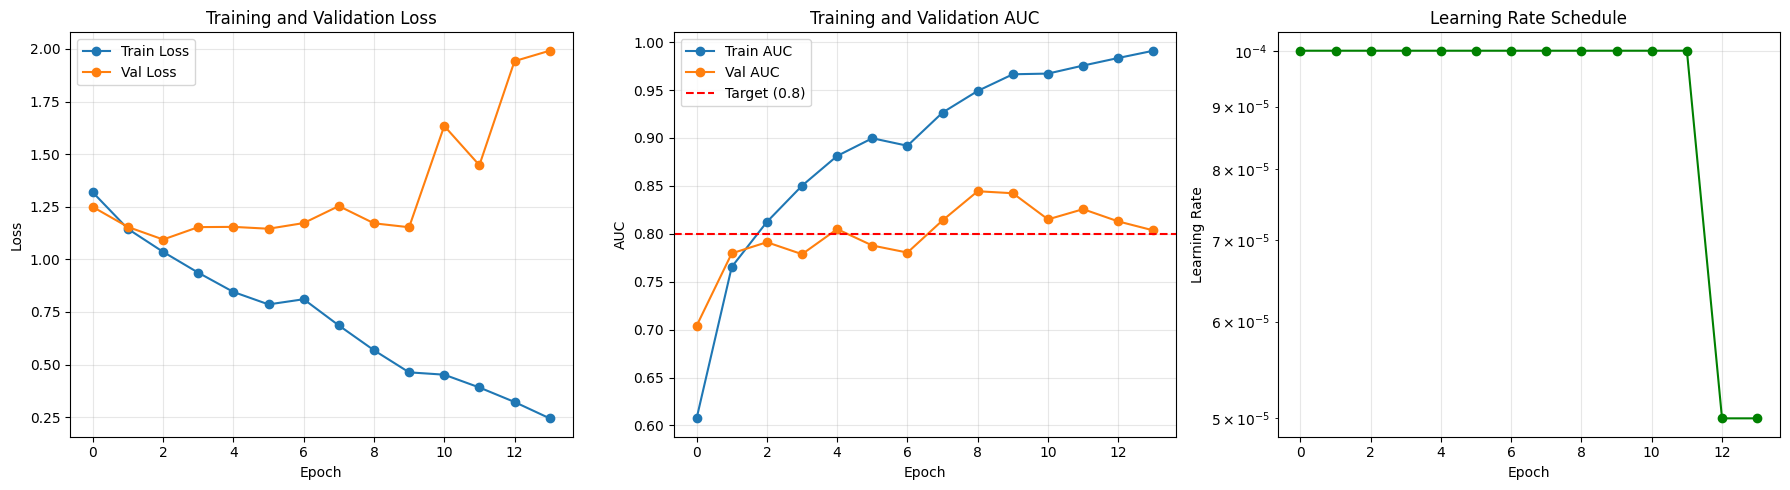


TESTING ON TEST SET


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# ==================== MAIN TRAINING LOOP ====================
print('\n' + '='*70)
print('STARTING TRAINING')
print('='*70)

# Training history
history = {
    'train_loss': [], 'train_auc': [],
    'val_loss': [], 'val_auc': [],
    'lr': []
}

best_val_auc = 0.0
patience_counter = 0

for epoch in range(config.NUM_EPOCHS):
    print(f'\n📅 Epoch {epoch+1}/{config.NUM_EPOCHS}')
    print('-'*70)

    epoch_start = time.time()

    # Train
    train_loss, train_auc, train_disease_auc = train_epoch(
        model, train_loader, criterion, optimizer, config.DEVICE
    )

    # Validate
    val_loss, val_auc, val_disease_auc, _, _ = validate(
        model, val_loader, criterion, config.DEVICE
    )

    # Learning rate scheduling
    scheduler.step(val_auc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start

    # Print results
    print(f'\n⏱️  Time: {epoch_time:.1f}s | LR: {current_lr:.6f}')
    print(f'📉 Train Loss: {train_loss:.4f} | Train AUC: {train_auc:.4f}')
    print(f'📊 Val Loss:   {val_loss:.4f} | Val AUC:   {val_auc:.4f}')

    print('\n🏥 Per-disease AUC (Validation):')
    for disease, auc_val in zip(config.DISEASES, val_disease_auc):
        status = '✅' if auc_val >= 0.80 else '⚠️'
        print(f'  {status} {disease:15s}: {auc_val:.4f}')

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_disease_auc': val_disease_auc,
            'config': vars(config)
        }
        torch.save(checkpoint, os.path.join(config.MODEL_DIR, 'best_model.pth'))
        print(f'\n💾 Best model saved! (AUC: {val_auc:.4f})')
    else:
        patience_counter += 1
        print(f'\n⏳ Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}')

    # Early stopping
    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print(f'\n🛑 Early stopping triggered after {epoch+1} epochs')
        break

print('\n' + '='*70)
print('✅ TRAINING COMPLETE!')
print('='*70)
print(f'Best validation AUC: {best_val_auc:.4f}')

# ==================== VISUALIZATION ====================
print('\n📊 Plotting training history...')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history['train_auc'], label='Train AUC', marker='o')
axes[1].plot(history['val_auc'], label='Val AUC', marker='o')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='Target (0.8)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Training and Validation AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'training_history.png'), dpi=150)
plt.show()

# ==================== TESTING ====================
print('\n' + '='*70)
print('TESTING ON TEST SET')
print('='*70)

# Load best model
checkpoint = torch.load(os.path.join(config.MODEL_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print('✅ Loaded best model')

# Test
test_loss, test_auc, test_disease_auc, test_labels, test_preds = validate(
    model, test_loader, criterion, config.DEVICE
)

print(f'\n📊 TEST RESULTS')
print('-'*70)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC (Average): {test_auc:.4f}')

print('\n🏥 Per-disease AUC (Test Set):')
for disease, auc_val in zip(config.DISEASES, test_disease_auc):
    status = '✅' if auc_val >= 0.80 else '⚠️'
    print(f'  {status} {disease:15s}: {auc_val:.4f}')

# Plot disease AUC
plt.figure(figsize=(10, 6))
colors = ['green' if auc >= 0.8 else 'orange' for auc in test_disease_auc]
bars = plt.bar(config.DISEASES, test_disease_auc, color=colors)
plt.xlabel('Disease')
plt.ylabel('AUC Score')
plt.title('Test Set: AUC Score per Disease')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.axhline(y=0.8, color='r', linestyle='--', label='Target (0.8)', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'test_disease_auc.png'), dpi=150)
plt.show()

# Save final results
results = {
    'best_val_auc': float(best_val_auc),
    'test_auc': float(test_auc),
    'test_disease_auc': {disease: float(auc) for disease, auc in zip(config.DISEASES, test_disease_auc)},
    'config': vars(config)
}

with open(os.path.join(config.MODEL_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f'\n💾 Results saved to {config.MODEL_DIR}')
print('='*70)
print('🎉 ALL DONE!')
print('='*70)

# Visualization and Testing


📊 Plotting training history...


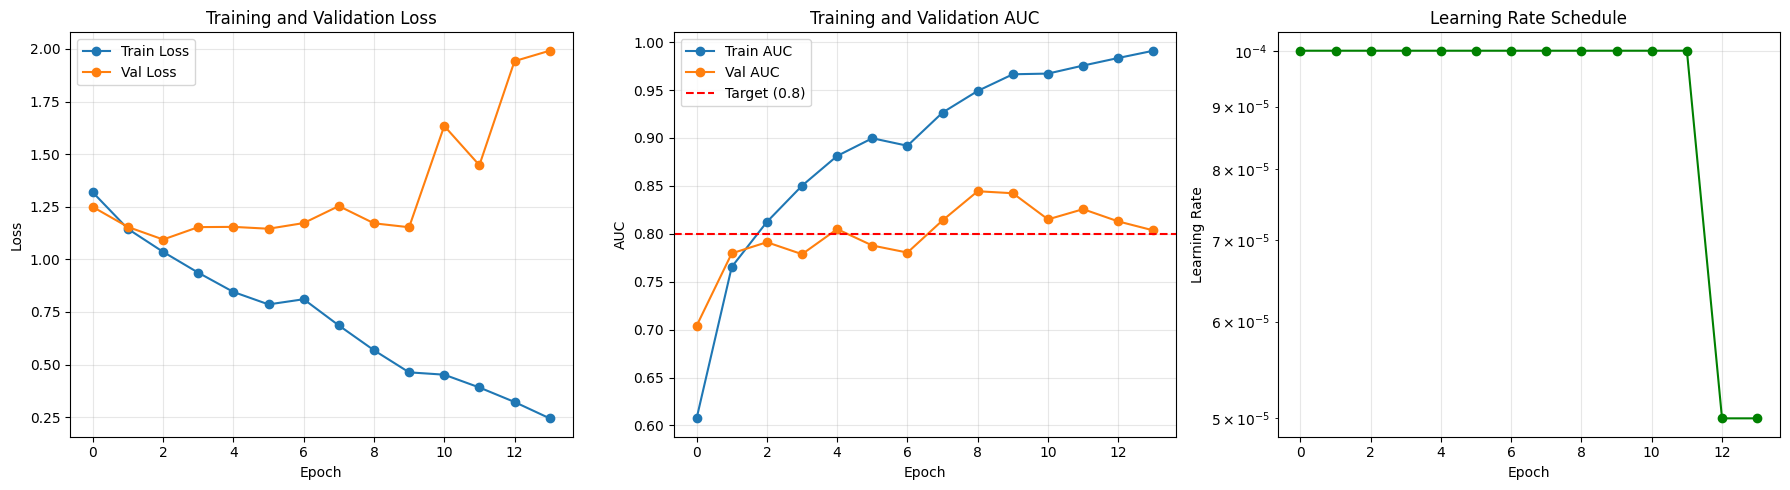


TESTING ON TEST SET
✅ Loaded best model



📊 TEST RESULTS
----------------------------------------------------------------------
Test Loss: 1.5430
Test AUC (Average): 0.7760

🏥 Per-disease AUC (Test Set):
  ✅ Cardiomegaly   : 0.8449
  ✅ Edema          : 0.8347
  ✅ Emphysema      : 0.8192
  ✅ Hernia         : 0.8290
  ⚠️ Pneumonia      : 0.6062
  ⚠️ Fibrosis       : 0.6625
  ✅ Pneumothorax   : 0.8352


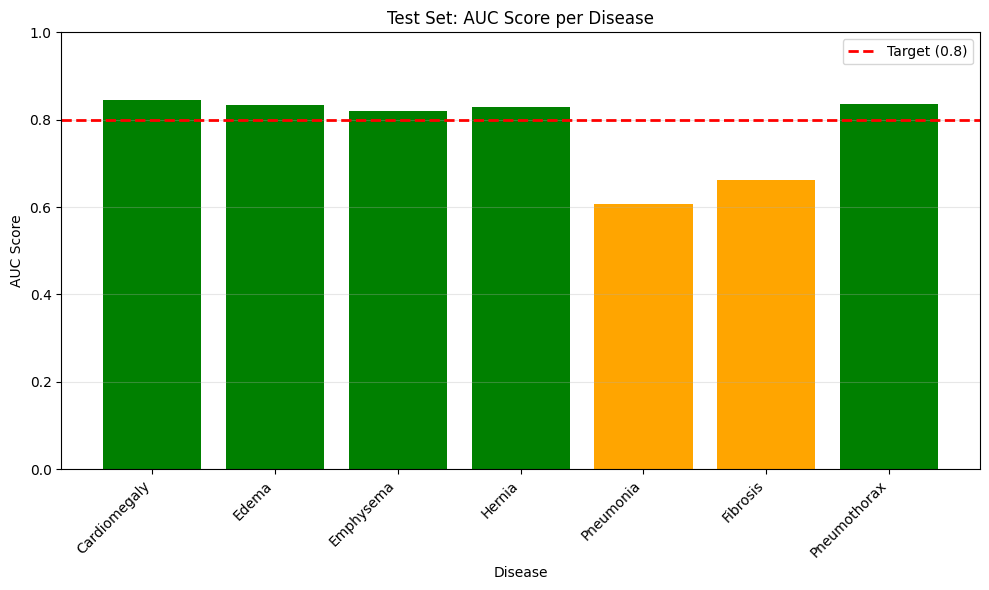


💾 Results saved to /content/drive/MyDrive/ML-Project/models_densenet
🎉 ALL DONE!


In [ ]:
# ==================== VISUALIZATION ====================
print('\n📊 Plotting training history...')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history['train_auc'], label='Train AUC', marker='o')
axes[1].plot(history['val_auc'], label='Val AUC', marker='o')
axes[1].axhline(y=0.8, color='r', linestyle='--', label='Target (0.8)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Training and Validation AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'training_history.png'), dpi=150)
plt.show()

# ==================== TESTING ====================
print('\n' + '='*70)
print('TESTING ON TEST SET')
print('='*70)

# Load best model
checkpoint = torch.load(os.path.join(config.MODEL_DIR, 'best_model.pth'), weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print('✅ Loaded best model')

# Test
test_loss, test_auc, test_disease_auc, test_labels, test_preds = validate(
    model, test_loader, criterion, config.DEVICE
)

print(f'\n📊 TEST RESULTS')
print('-'*70)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test AUC (Average): {test_auc:.4f}')

print('\n🏥 Per-disease AUC (Test Set):')
for disease, auc_val in zip(config.DISEASES, test_disease_auc):
    status = '✅' if auc_val >= 0.80 else '⚠️'
    print(f'  {status} {disease:15s}: {auc_val:.4f}')

# Plot disease AUC
plt.figure(figsize=(10, 6))
colors = ['green' if auc >= 0.8 else 'orange' for auc in test_disease_auc]
bars = plt.bar(config.DISEASES, test_disease_auc, color=colors)
plt.xlabel('Disease')
plt.ylabel('AUC Score')
plt.title('Test Set: AUC Score per Disease')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.axhline(y=0.8, color='r', linestyle='--', label='Target (0.8)', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(config.MODEL_DIR, 'test_disease_auc.png'), dpi=150)
plt.show()

# Save final results
results = {
    'best_val_auc': float(best_val_auc),
    'test_auc': float(test_auc),
    'test_disease_auc': {disease: float(auc) for disease, auc in zip(config.DISEASES, test_disease_auc)},
    'config': vars(config)
}

with open(os.path.join(config.MODEL_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f'\n💾 Results saved to {config.MODEL_DIR}')
print('='*70)
print('🎉 ALL DONE!')
print('='*70)

In [ ]:
import pickle
import os

# Define the path to save the pickle file
pkl_filepath = os.path.join(config.MODEL_DIR, 'densenet_classifier.pkl')

# Save the model to a pickle file
with open(pkl_filepath, 'wb') as f:
    pickle.dump(model, f)

print(f"✅ Model saved as pickle file at: {pkl_filepath}")

✅ Model saved as pickle file at: /content/drive/MyDrive/ML-Project/models_densenet/densenet_classifier.pkl
